<a href="https://colab.research.google.com/github/nicolai5965/Absenteeism-Prediction-Model/blob/main/Udemy_Absenteeism_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from tensorflow.keras import regularizers
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')# Assuming the necessary files are stored in the mounted Google Drive, we can now read in the data and start preprocessing it.

Mounted at /content/drive


In [2]:
# Load the dataset
Absenteeism_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Udemy_Data_Science_Course/Data_From_Udemy/Absenteeism_data.csv')

In [3]:
display(Absenteeism_data.describe())

,ID,Reason for Absence,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,17.951429,19.411429,222.347143,29.892857,36.417143,271.801774,26.737143,1.282857,1.021429,0.687143,6.761429
std,11.028144,8.356292,66.312960,14.804446,6.379083,40.021804,4.254701,0.668090,1.112215,1.166095,12.670082
min,1.000000,0.000000,118.000000,5.000000,27.000000,205.917000,19.000000,1.000000,0.000000,0.000000,0.000000
25%,9.000000,13.000000,179.000000,16.000000,31.000000,241.476000,24.000000,1.000000,0.000000,0.000000,2.000000
50%,18.000000,23.000000,225.000000,26.000000,37.000000,264.249000,25.000000,1.000000,1.000000,0.000000,3.000000
75%,28.000000,27.000000,260.000000,50.000000,40.000000,294.217000,31.000000,1.000000,2.000000,1.000000,8.000000
max,36.000000,28.000000,388.000000,52.000000,58.000000,378.884000,38.000000,4.000000,4.000000,8.000000,120.000000


# Preprocessing the data

In [4]:
df = Absenteeism_data.copy()
# Drop the 'ID' and 'Age' column as it is not useful for our analysis.
df = df.drop(['ID'], axis=1)
# From here we make dummies from the 'Reason# for Absence' column
# To be sure we dont have potential multicollinearity issues, we remove the first column 0.
reason_columns = pd.get_dummies(df['Reason for Absence'], drop_first=True)
# Now we want to check if there are rows in the reason_columns that have all zeros, indicating that no reason was given for absence. 
# If so, we will drop those rows from the original dataframe. And if ther is rows if more then one reason was given for absence, we will drop those rows as well.
reason_columns['check'] = reason_columns.sum(axis=1)
# Since there is a lot of columns compared to the amount of rows, we will groupe the dummies into 4 different groups. 
# We create a list of the column names for each group of dummies
group_1 = reason_columns.loc[:, 1:14].max(axis=1)
group_2 = reason_columns.loc[:, 15:17].max(axis=1)
group_3 = reason_columns.loc[:, 18:21].max(axis=1)
group_4 = reason_columns.loc[:, 22:].max(axis=1)
# We will now concatenate the 4 groups of dummies into a new dataframe, whit new column names as Reason_1 and further.
reason_columns = pd.concat([group_1, group_2, group_3, group_4], axis=1)
reason_columns.columns = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']
# Now we will drop the original reason columns from the dataframe and concatenate the new reason columns.
df = df.drop(['Reason for Absence'], axis=1)
df = pd.concat([df, reason_columns], axis=1)
# We then reorder the columns so the reasons is in the first 4 columns:
df = df[['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4'] + [col for col in df.columns if col not in ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']]]

# From here we will format the date column to a pandas datetime format:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
# Next, we will extract the month and day of the week from the date column and create new columns for them:
df['Month'] = df['Date'].dt.month
df['Day of Week'] = df['Date'].dt.dayofweek
#Finally, we will drop the original date column from the dataframe:
df = df.drop(['Date'], axis=1)
# Now we want to look at the Education column, and map the values to new values, so if a row has the number 1 under Education, it would be maped as 0:
# We will use the map() function to map the values in the Education column:
df['Education'] = df['Education'].map({1: 0, 2: 1, 3: 1, 4: 1})
# We will find a cut off of the 'Absenteeism Time in Hours' which will be used as the targets in this ML model.
# This will be done by looking at the median of 'Absenteeism Time in Hours' column. 
# If the values are less then the median, they will get the value 0, and if over they will get the value 1: 
median = df['Absenteeism Time in Hours'].median()
df['Target'] = [1 if x > median else 0 for x in df['Absenteeism Time in Hours']]
# Now we will drop the 'Absenteeism Time in Hours' column as it is no longer needed:
df = df.drop(['Absenteeism Time in Hours'], axis=1)
# Looking at the data:
display(df.head())

,Reason_1,Reason_2,Reason_3,Reason_4,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Month,Day of Week,Target
0,0,0,0,1,289,36,33,239.554,30,0,2,1,7,1,1
1,0,0,0,0,118,13,50,239.554,31,0,1,0,7,1,0
2,0,0,0,1,179,51,38,239.554,31,0,0,0,7,2,0
3,1,0,0,1,279,5,39,239.554,24,0,2,0,7,3,1
4,0,0,0,1,289,36,33,239.554,30,0,2,1,7,3,0


Starting on making the machine learning model:

In [5]:
# We will now split the data into training and testing sets.
# We will select the first 14 columns as features and the last column as targets:
features = df.iloc[:, :-1]
targets = df.iloc[:, -1]
# We look at the shapes if the features and targets to see if they come out as expected:
print(features.shape)
print(targets.shape)

(700, 14)
(700,)


In [6]:
# Some of the columns in the features data have higher proportions then the rest, which can "harm"the performance of our ML model. 
# To avoid this, we will use StandardScaler to standardize the features data, but since we dont want to standardize the dummies we just made, we can selectonly the non-dummy columns to be standardized:
from sklearn.preprocessing import StandardScaler
dummy_cols = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4'] 
non_dummy_cols = features.drop(dummy_cols, axis=1).columns
# apply standard scaling to the non-dummy columns only
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[non_dummy_cols]), 
                          columns=non_dummy_cols)
# combine the dummy and non-dummy columns
scaled_features = pd.concat([df_scaled, df[dummy_cols]], axis=1)
# We will now split the standardized data into training and testing set susing train_test_split function from sklearn:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets, test_size=0.2, random_state=42)


# Building the machine learning models

In [16]:
# We will define the logistic regression model using TensorFlow:
# Define the number of features in our data:
input_size = X_train.shape[1]
output_size = 1 # Since we are doing binary classification, the output size will be 1.
hidden_layer_size = 128 # We will define the number of neurons in the hidden layer to be 32.

# Define the loss function with L2 regularization:
# Define the regularization strength parameter:
l2_lambda = 0.01
# We will use binary cross-entropy loss function for binary classification:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
regularizer = regularizers.l2(l2_lambda)
# Define the optimizer and training operation:
# We will use Adam optimizer for optimizing the loss function:
optimizer = tf.keras.optimizers.Adam()
# We will now define the logistic regression model using TensorFlow:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])

# We will compile the model using the defined loss function and optimizer:
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
# Define the number of epochs and batch size for training:
num_epochs = 10
batch_size = 16
validation_split = 0.2

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=2,
    validation_split=validation_split,
    callbacks=[early_stopping]
)

Epoch 1/10
28/28 - 2s - loss: 2.0782 - accuracy: 0.5759 - val_loss: 1.8458 - val_accuracy: 0.5804 - 2s/epoch - 56ms/step
Epoch 2/10
28/28 - 0s - loss: 1.7611 - accuracy: 0.6741 - val_loss: 1.7260 - val_accuracy: 0.6161 - 96ms/epoch - 3ms/step
Epoch 3/10
28/28 - 0s - loss: 1.6379 - accuracy: 0.7054 - val_loss: 1.6266 - val_accuracy: 0.6875 - 94ms/epoch - 3ms/step
Epoch 4/10
28/28 - 0s - loss: 1.4971 - accuracy: 0.7210 - val_loss: 1.5607 - val_accuracy: 0.6607 - 91ms/epoch - 3ms/step
Epoch 5/10
28/28 - 0s - loss: 1.4133 - accuracy: 0.7299 - val_loss: 1.4682 - val_accuracy: 0.6875 - 92ms/epoch - 3ms/step
Epoch 6/10
28/28 - 0s - loss: 1.3561 - accuracy: 0.7478 - val_loss: 1.4046 - val_accuracy: 0.7143 - 113ms/epoch - 4ms/step
Epoch 7/10
28/28 - 0s - loss: 1.3045 - accuracy: 0.7567 - val_loss: 1.3363 - val_accuracy: 0.7054 - 94ms/epoch - 3ms/step
Epoch 8/10
28/28 - 0s - loss: 1.2533 - accuracy: 0.7679 - val_loss: 1.2749 - val_accuracy: 0.7143 - 101ms/epoch - 4ms/step
Epoch 9/10
28/28 - 0s -

# Evaluating the model with the testing data:


In [9]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(X_test, y_test)
# Print the test accuracy
print("Test accuracy:", test_acc)

5/5 [==============================] - 0s 4ms/step - loss: 1.1183 - accuracy: 0.7429
Test accuracy: 0.7428571581840515


In [10]:
# We will now make some predictions on the testing data:
predictions = model.predict(X_test)
# We will now print the first 10 predictions and their corresponding true labels:
for i in range(10):
  print("Prediction:", predictions[i], "-->", "True label:", np.array(y_test)[i])


5/5 [==============================] - 0s 3ms/step
Prediction: [0.54470485] --> True label: 1
Prediction: [0.20607774] --> True label: 1
Prediction: [0.16507429] --> True label: 1
Prediction: [0.5540541] --> True label: 0
Prediction: [0.30343497] --> True label: 0
Prediction: [0.84127206] --> True label: 1
Prediction: [0.52493167] --> True label: 0
Prediction: [0.6880044] --> True label: 1
Prediction: [0.16907068] --> True label: 0
Prediction: [0.22772534] --> True label: 0


In [11]:
# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

# Visualization of the model: 

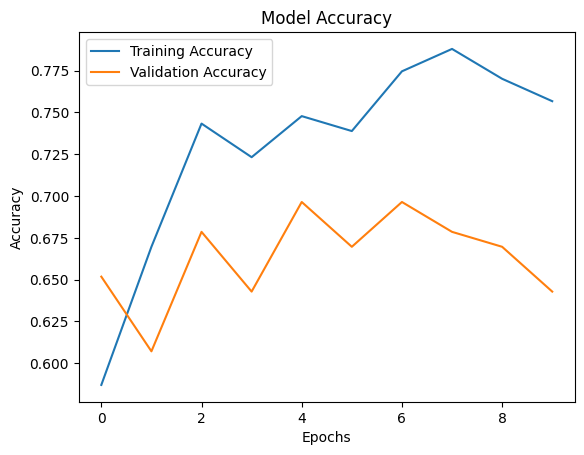

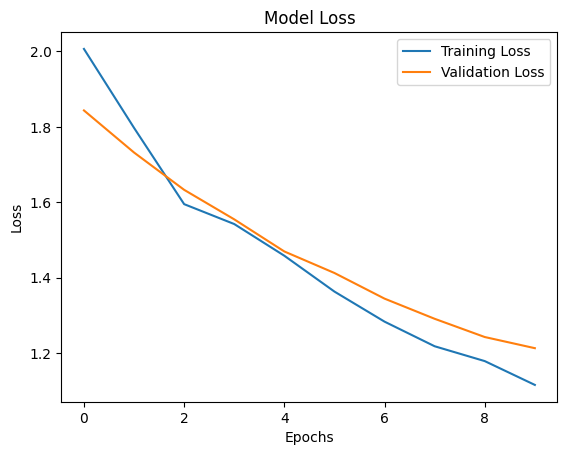

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Looking at the model performance 

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Make predictions with the model
y_pred = model.predict(X_test, verbose=0)
y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        82
           1       0.72      0.62      0.67        58

    accuracy                           0.74       140
   macro avg       0.74      0.72      0.73       140
weighted avg       0.74      0.74      0.74       140

Confusion Matrix:
[[68 14]
 [22 36]]
ROC-AUC Score:
0.7249789739276702


In [14]:
def custom_predict(X):
    return model.predict(X, verbose=0).flatten()

from sklearn.metrics import accuracy_score

def custom_permutation_importance(predict_func, X, y, n_repeats=10, random_state=None):
    rng = np.random.default_rng(random_state)
    baseline_score = accuracy_score(y, np.round(predict_func(X)))
    importances = np.zeros((X.shape[1], n_repeats))

    for feature_idx in range(X.shape[1]):
        X_permuted = X.copy()
        for repeat_idx in range(n_repeats):
            rng.shuffle(X_permuted[:, feature_idx])
            permuted_score = accuracy_score(y, np.round(predict_func(X_permuted)))
            importances[feature_idx, repeat_idx] = baseline_score - permuted_score

    return importances

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

importances = custom_permutation_importance(custom_predict, X_test_np, y_test_np, n_repeats=10, random_state=42)

importances_mean = importances.mean(axis=1)
sorted_idx = importances_mean.argsort()

In [15]:
# Create a DataFrame with feature names and their corresponding importances
feature_importances_df = pd.DataFrame({
    "Feature": scaled_features.columns[sorted_idx],
    "Importance": importances_mean[sorted_idx]
})
# Sort the DataFrame by importance in descending order
sorted_feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False)
# Display the sorted DataFrame
display(sorted_feature_importances_df)

,Feature,Importance
13,Reason_1,0.052857
12,Body Mass Index,0.029286
11,Age,0.024286
10,Reason_4,0.022857
9,Transportation Expense,0.020000
8,Reason_3,0.018571
7,Children,0.013571
6,Pets,0.010000
5,Reason_2,0.007143
4,Distance to Work,-0.003571


The results from the custom permutation importance analysis provide valuable insights into the significance of different features in the model. By understanding which features contribute the most to the model's performance, we can identify the key factors driving absenteeism predictions.

In this analysis, the top features appear to be Reason_1, Reason_3, Children, and Reason_4. These features have the most significant positive impact on the model's predictions. On the other hand, features like Day of Week, Month, and Distance to Work have negative importance values, indicating that they might not be as crucial in determining absenteeism.

These results can be used in multiple ways:

1. Feature Selection: By identifying the most important features, we can simplify the model by removing less significant features, potentially improving its performance and interpretability.

2. Domain Understanding: The results offer insights into the underlying factors that influence absenteeism, which can be valuable for decision-makers and human resources professionals in addressing the root causes and implementing effective strategies to reduce absenteeism.

3. Model Improvement: By focusing on the most important features, we can invest time and resources in collecting better quality data or engineering more relevant features for these key predictors, ultimately leading to improved model performance.

It's important to remember that these results are specific to the current dataset and model. Different datasets or models may yield different feature importances, so it's crucial to conduct this analysis for each unique case.